In [2]:
#default_exp estimators.tree

#TODO: make gaussian process interface
#TODO: make meta bagged randomized prior class
#TODO: make gaussian likelihood partition criteria in forest - MAY NOT BE POSSIBLE DUE TO SKLEARN IMPLEMENTATION
#TODO: implement EmpiricalDistribution Class
#TODO: make boosting meta estimators using tree weights in sampling process
#TODO: implement bagging and boosting meta estimator (include sampling from sub models)
#TODO: include target scaling in pipeline
#TODO: instead of sampling, return an empirical distribution (histograms) with value and normalized frequency (proportional to similarity)

In [3]:
#hide
from nbdev.showdoc import *

# Tree based density estimators -

Density estimators based on DecisionTree algorithms. They're very useful because they handle well heterogeneous data

In [166]:
#export
from warnings import warn

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, normalize, QuantileTransformer, FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor

try:
    from sparse_dot_topn import awesome_cossim_topn
except ImportError as e:
    warn(f"{e}")
    warn("sparse_dot_topn module not installed, will use sklearn NearestNeighbors for vector query")
    

In [199]:
# export

def cos_sim_query(query_vector, query_space, n_neighbors=50, lower_bound=0.0):
    
    try:
        sim_matrix = awesome_cossim_topn(normalize(query_vector), normalize(query_space).T,
                                         ntop=n_neighbors, lower_bound=lower_bound)
    except NameError:
        sim_matrix = None
        raise NotImplementedError('Implement sim_matrix calculation using some SKlearn avalible method and returning topn')
        
    sim_matrix = sim_matrix.tocoo()
    indexes = []
    sim = []
    for row in range(len(X)):
        sim.append(sim_matrix.data[sim_matrix.row == row])
        indexes.append(sim_matrix.col[sim_matrix.row == row])
        
    return indexes, sim


class CustomMultiOutputRegressor(MultiOutputRegressor):
    '''Custom multioutput for multioutput cases except random forests (which handles multi output directly)'''
    def apply(self,X):
        result = [estim.apply(X) for estim in self.estimators_]
        return np.concatenate(result, axis = -1)

class EnsembleTreesDensityBase:    
    '''Base Class containing important methods for building Naive and Similarity Density Tree estimators'''
    def _fit_leaf_sample_graph(self, X):
        nodes_array = self.apply(X)
        encoder = OneHotEncoder()
        self.leaf_node_graph = encoder.fit_transform(nodes_array)
        self.encoder = encoder

    def _make_leaf_node_graph(self, X):
        return self.encoder.transform(self.apply(X))

    def _make_leaf_node_data(self, X, y):
        # create node to data mapper
        y = pd.DataFrame(y)
        node_indexes = self.apply(X)
        tree_node_values_mapper_list = []
        for tree in range(node_indexes.shape[1]):
            tree_node_values_mapper_list.append(dict(
                y.assign(_NODE=node_indexes[:, tree]).groupby('_NODE').apply(
                    lambda x: [x[col].values.tolist() for col in x if not col == '_NODE'])))
        return dict(enumerate(tree_node_values_mapper_list))
    
    def _similarity_sample(self, X, n_samples = 100, n_neighbors = 10, lower_bound = 0.0, sample_weights = None, alpha = 1):
        idx, sim = cos_sim_query(
            self._make_leaf_node_graph(X), self.leaf_node_graph, n_neighbors=n_neighbors, lower_bound=lower_bound)        
                
        p = self._handle_sample_weights(sample_weights, sim, alpha)        
        samples = []
        for i in range(len(idx)):            
            sampled_idxs = np.random.choice(idx[i], size = n_samples, replace = True, p = p[i])
            samples.append(self.y_[sampled_idxs])
        
        return np.array(samples)
    
    def _similarity_emprical_pdf(self, X, n_neighbors = 30, lower_bound = 0.0, sample_weights = None, alpha = 1):
        idx, sim = cos_sim_query(
            self._make_leaf_node_graph(X), self.leaf_node_graph, n_neighbors=n_neighbors, lower_bound=lower_bound)
        p = self._handle_sample_weights(sample_weights, sim, alpha)
    
    def _handle_sample_weights(self, sample_weights, sim, alpha):
        
        if sample_weights is None:            
            return [normalize((i**alpha).reshape(1,-1) + 1e-9, norm = 'l1').flatten() for i in sim]            
        
        else:
            return [normalize((sample_weights(i)).reshape(1,-1) + 1e-9, norm = 'l1').flatten() for i in sim]
        
# any tree regressor can be used as long as it has a apply method which returns the leaf nodes
        
class SimilarityForestMixin(EnsembleTreesDensityBase):
        
    def fit(self, X, y = None):        
        self.estimator.fit(X,y)        
        self._fit_leaf_sample_graph(X)
        self.y_ = y
        return self
    
    def sample(self, X, n_samples = 100, n_neighbors = 10, lower_bound = 0.0, sample_weights = None, alpha = 1):
        return self._similarity_sample(X, n_samples, n_neighbors, lower_bound, sample_weights, alpha)

class NaiveForestMixin(EnsembleTreesDensityBase):
    
    def fit(self, X, y = None):
        self.estimator.fit(X,y)
        self.tree_node_values_mapper = self._make_leaf_node_data(X, y)
        self.y_dim = y.shape[-1] if len(y.shape) > 1 else 1
        return self

    def sample(self, X):
        node_indexes = self.apply(X)
        drawn_samples = []
        for sample in range(node_indexes.shape[0]):
            row_samples = [[] for _ in range(self.y_dim)]
            for tree in range(node_indexes.shape[1]):
                node = node_indexes[sample, tree]
                sampled_values = self.tree_node_values_mapper[tree][node]
                for dimension in range(len(sampled_values)):
                    row_samples[dimension] += sampled_values[dimension]
            drawn_samples.append(np.array(row_samples).reshape(-1,self.y_dim))
        return drawn_samples


class SimilarityTreeEnsemble(SimilarityForestMixin):
    def __init__(self, estimator):
        self.estimator = estimator
        return
    def __getattr__(self, attr):        
        try:
            return getattr(super(),attr)
        except AttributeError:
            return getattr(self.estimator, attr)
    
class NaiveTreeEnsemble(NaiveForestMixin):
    def __init__(self, estimator):
        self.estimator = estimator
        return
    def __getattr__(self, attr):        
        try:
            return getattr(super(),attr)
        except AttributeError:
            return getattr(self.estimator, attr)

    
    
class SimilarityExtraTrees(SimilarityForestMixin, ExtraTreesRegressor):
    pass

class NaiveRandomForest(NaiveForestMixin, RandomForestRegressor):
    pass

class NaiveExtraTrees(NaiveForestMixin, ExtraTreesRegressor):
    pass

## TreeEstimator - 

Estimates the conditional distribution based on leaf samples

## NaiveForestEstimator - 

Estimates the conditional distribution based on leaf samples of all generated trees in the forest

# ForestSimilarityEstimator - 

Estimates the conditional distribution based on samples from dataset taking into account the `leaf_sample_graph`

## Tests

In [200]:
#
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.preprocessing import QuantileTransformer
def make_heterogeneous_regression():
    pass

X,y = make_regression(
    n_samples=10000,
    n_features=30,
    n_informative=15,
    n_targets=2,
    bias=0.5,
    effective_rank=None,
    tail_strength=1,
    noise=0.2,
    shuffle=True,
    coef=False,
    random_state=None
)

In [201]:
qt = QuantileTransformer(output_distribution = 'normal')
#y = qt.fit_transform(y)

In [211]:
estimator = RandomForestRegressor(n_estimators = 10,min_samples_leaf = 3)#CustomMultiOutputRegressor(RandomForestRegressor(n_estimators = 10,min_samples_leaf = 3), n_jobs = -1)
density_estimator = SimilarityTreeEnsemble(estimator).fit(X,y)

In [222]:
samples = density_estimator.sample(X, alpha = 1, n_neighbors = 30)

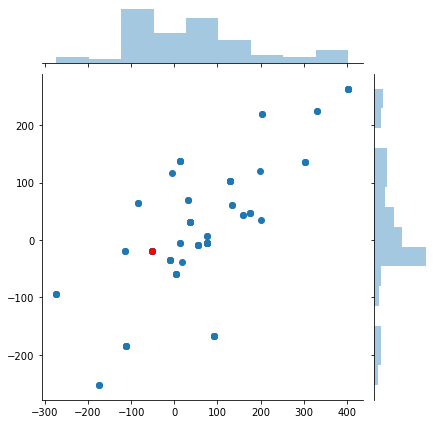

In [225]:
point += 1
jntplot = sns.jointplot(samples[point][:,0], samples[point][:,1], alpha = 1)
jntplot.ax_joint.scatter(y[point,0], y[point,1], color = 'r')

In [63]:
idx,sim = cos_sim_query(
            estimator._make_leaf_node_graph(X), estimator.leaf_node_graph, n_neighbors=10, lower_bound=0) 

In [65]:
estimator.y_[idx[0]]

array([[103.9979431 , 315.94818508],
       [298.09277851, 566.24813889],
       [333.24640175, 478.15264268],
       [253.30656716, 407.73899743],
       [363.14181069, 382.07661392],
       [104.03943829, 275.55028334],
       [ 36.65385617, 204.35724787]])